# PW1 - Handwritten character recognition


In [74]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Joakim Fellbom"
assert your_name

In [75]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [76]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F


In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [78]:
NUM_EPOCH = 2

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [79]:
root_dir = './data/MNIST/'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # moyenne et écart-type de MNIST
])

train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)

test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

Nombre d'exemples dans le training set : 60000
Nombre d'exemples dans le test set : 10000


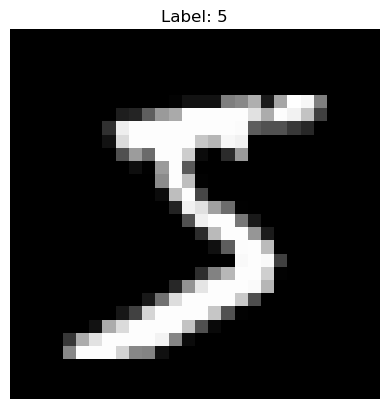

In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print(f"Nombre d'exemples dans le training set : {len(train_dataset)}")
print(f"Nombre d'exemples dans le test set : {len(test_dataset)}")

image, label = train_dataset[0]
plt.imshow(image.squeeze(0), cmap='gray')  # squeeze(0) enlève le canal unique (1, 28, 28) → (28, 28)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [81]:
print(f"Dimension d'entrée : {image.shape}")

Dimension d'entrée : torch.Size([1, 28, 28])


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

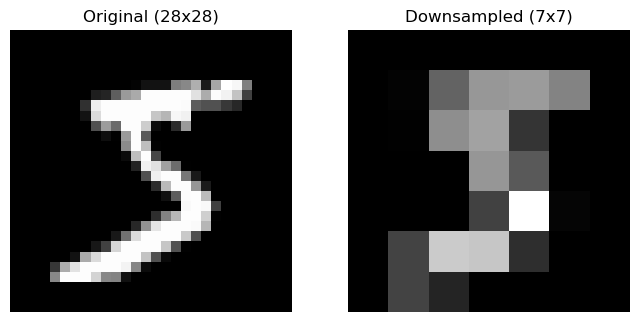

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def preprocess(x):
    """
    Downsample de 28x28 → 7x7 puis flatten.
    Entrée x : tensor shape (batch_size, 1, 28, 28)
    Sortie : shape (batch_size, 49)
    """
    x = F.avg_pool2d(x, kernel_size=4)  # 28x28 → 7x7
    return x.view(x.size(0), -1)  # flatten → (batch_size, 49)

sample_img, label = train_dataset[0]  # tensor de shape (1, 28, 28)
downsampled = F.avg_pool2d(sample_img.unsqueeze(0), kernel_size=4).squeeze()  # → (7, 7)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title("Original (28x28)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(downsampled, cmap='gray')
plt.title("Downsampled (7x7)")
plt.axis("off")

plt.show()

In [83]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(7 * 7, 10)  # 49 → 10 classes

    def forward(self, x):
        x = preprocess(x)  # downsample & flatten
        return self.linear(x)

In [84]:
model = LinearModel()
print(model)

LinearModel(
  (linear): Linear(in_features=49, out_features=10, bias=True)
)


## A.2 - Loss and optimizer
Create a cross entropy loss.

In [85]:
criterion = nn.CrossEntropyLoss()

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [86]:
def train(model, epoch, preprocess, lr):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)  # forward
        loss = criterion(output, target)  # loss
        loss.backward()  # backward
        optimizer.step()  # update weights

        # Calcul de la précision
        preds = output.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)

    train_accuracy = 100. * correct / total
    print(f"Train Epoch: {epoch} \tAccuracy: {train_accuracy:.2f}%")

    return optimizer, train_accuracy

def test(model, preprocess):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [90]:
def train_and_test(model, num_epoch, lr):
    for epoch in range(1, num_epoch + 1):
        optimizer, train_acc = train(model, epoch, preprocess, lr)
        test_acc = test(model, preprocess)

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [88]:
learning_rates = [1e-3, 1e-2, 1e-1]
NUM_EPOCH = 2

results = {}

for lr in learning_rates:
    print(f"\n=== Testing learning rate: {lr} ===")
    
    model = LinearModel()  # reset model à chaque fois
    
    train_and_test(model, 2, lr)



=== Testing learning rate: 0.001 ===
Train Epoch: 1 	Accuracy: 32.10%
Test Accuracy: 50.45%
Train Epoch: 2 	Accuracy: 55.79%
Test Accuracy: 61.71%

=== Testing learning rate: 0.01 ===
Train Epoch: 1 	Accuracy: 64.52%
Test Accuracy: 80.56%
Train Epoch: 2 	Accuracy: 81.17%
Test Accuracy: 83.50%

=== Testing learning rate: 0.1 ===
Train Epoch: 1 	Accuracy: 82.35%
Test Accuracy: 86.69%
Train Epoch: 2 	Accuracy: 86.22%
Test Accuracy: 87.63%


## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [ ]:
class MLP(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        layers = []

        input_dim = 7 * 7  # après preprocess
        output_dim = 10    # nombre de classes MNIST

        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())

        for _ in range(depth - 2):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        if depth > 1:
            layers.append(nn.Linear(width, output_dim))
        else:
            layers[0] = nn.Linear(input_dim, output_dim)

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = preprocess(x)  # downsample et flatten
        return self.net(x)

In [ ]:
depth_list = [1, 2, 3, 4]
width_list = [32, 64, 128]

results = {}

for depth in depth_list:
    for width in width_list:
        print(f"\n ========Training MLP with depth={depth}, width={width}=========")
        
        model = MLP(width=width, depth=depth)

        train_and_test(model, 2, lr=0.1)



 ========Training MLP with depth=1, width=32=========
Train Epoch: 1 	Accuracy: 78.26%
Test Accuracy: 86.69%
Train Epoch: 2 	Accuracy: 86.22%
Test Accuracy: 87.69%

 ========Training MLP with depth=1, width=64=========
Train Epoch: 1 	Accuracy: 66.88%
Test Accuracy: 72.85%
Train Epoch: 2 	Accuracy: 73.35%
Test Accuracy: 74.78%

 ========Training MLP with depth=1, width=128=========
Train Epoch: 1 	Accuracy: 60.24%
Test Accuracy: 66.28%
Train Epoch: 2 	Accuracy: 65.80%
Test Accuracy: 67.53%

 ========Training MLP with depth=2, width=32=========
Train Epoch: 1 	Accuracy: 82.75%
Test Accuracy: 89.43%
Train Epoch: 2 	Accuracy: 89.39%
Test Accuracy: 90.84%

 ========Training MLP with depth=2, width=64=========
Train Epoch: 1 	Accuracy: 83.47%
Test Accuracy: 88.90%
Train Epoch: 2 	Accuracy: 89.86%
Test Accuracy: 91.75%

 ========Training MLP with depth=2, width=128=========
Train Epoch: 1 	Accuracy: 84.46%
Test Accuracy: 90.16%
Train Epoch: 2 	Accuracy: 90.59%
Test Accuracy: 92.37%

 ======

# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)  # (28x28 → 26x26)
        self.pool = nn.MaxPool2d(kernel_size=2)  # (26x26 → 13x13)
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(8 * 13 * 13, 10)

    def forward(self, x):
        x = self.conv(x)       # (batch, 8, 26, 26)
        x = self.relu(x)
        x = self.pool(x)       # (batch, 8, 13, 13)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)         # (batch, 10)
        return x

In [91]:
model = ConvModel()

def preprocess(x):
    return x

train_and_test(model, num_epoch=5, lr=0.1)

Train Epoch: 1 	Accuracy: 93.50%
Test Accuracy: 96.71%
Train Epoch: 2 	Accuracy: 97.33%
Test Accuracy: 97.75%
Train Epoch: 3 	Accuracy: 97.87%
Test Accuracy: 97.46%
Train Epoch: 4 	Accuracy: 98.19%
Test Accuracy: 98.17%
Train Epoch: 5 	Accuracy: 98.42%
Test Accuracy: 98.17%


You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [92]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()

        # Convolution : (28x28 → 26x26) puis MaxPool → (13x13)
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()

        # Taille de l'entrée pour les couches linéaires : 8 * 13 * 13
        flattened_dim = 8 * 13 * 13

        # Trois couches fully connected avec ReLU
        self.fc1 = nn.Linear(flattened_dim, h)
        self.fc2 = nn.Linear(h, h)
        self.fc3 = nn.Linear(h, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))      # (batch, 8, 13, 13)
        x = x.view(x.size(0), -1)                   # flatten

        x = self.relu(self.fc1(x))                  # (batch, h)
        x = self.relu(self.fc2(x))                  # (batch, h)
        x = self.fc3(x)                             # (batch, 10)

        return x

In [93]:
model = ConvDeepModel()

def preprocess(x):
    return x

train_and_test(model, num_epoch=5, lr=0.1)

Train Epoch: 1 	Accuracy: 91.05%
Test Accuracy: 96.32%
Train Epoch: 2 	Accuracy: 97.43%
Test Accuracy: 97.60%
Train Epoch: 3 	Accuracy: 98.27%
Test Accuracy: 98.20%
Train Epoch: 4 	Accuracy: 98.71%
Test Accuracy: 98.34%
Train Epoch: 5 	Accuracy: 99.08%
Test Accuracy: 98.42%


## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

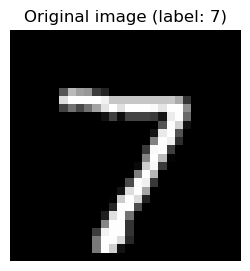

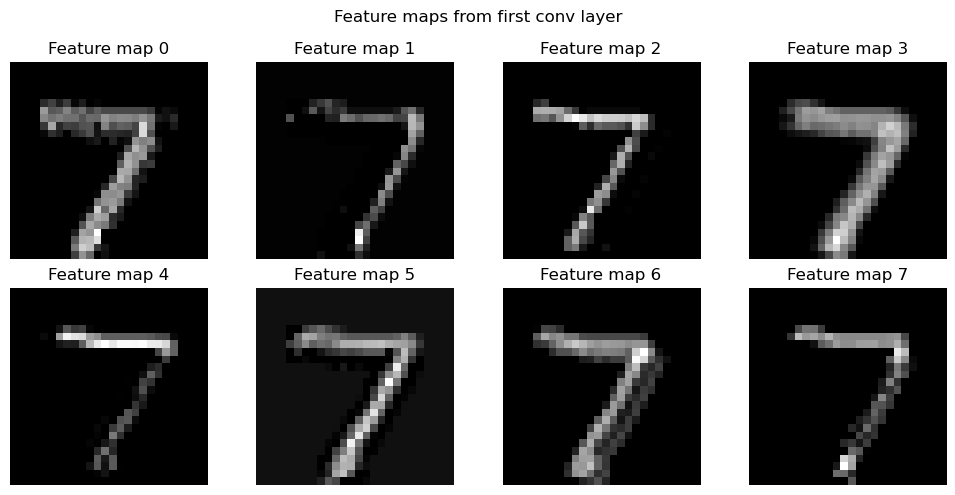

In [94]:
model = ConvDeepModel()
model.eval()

img, label = test_dataset[0]  # shape: (1, 28, 28)
img_input = img.unsqueeze(0)  # ajouter batch dim → (1, 1, 28, 28)

with torch.no_grad():
    conv_output = model.conv(img_input)           # shape: (1, 8, 26, 26)
    feature_maps = model.relu(conv_output).squeeze(0)  # remove batch dim → (8, 26, 26)

plt.figure(figsize=(3, 3))
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Original image (label: {label})")
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(feature_maps[i], cmap='gray')
    plt.title(f"Feature map {i}")
    plt.axis('off')

plt.suptitle("Feature maps from first conv layer")
plt.tight_layout()
plt.show()

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?  
--> channels

In [95]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(d, h)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(h, d)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return x + out

In [96]:
class ConvResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ConvResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return x + out

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer.   
  

Can you match the accuracy of the two-layer network ?
    Oui en modifiant l, h et k
      
 Can you exceed it ?  Oui avec l=3, h=70 et k=2 
   
  What happens when you increase the number of layers ? Pas forcément bcp de changements entre 2 et 3. Quand on augmente + l'accuracy augmente légèrement.
     
   Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?  
Oui, on en a bcp moins que pour le ConvDeepModel

In [97]:
class ResidualModel(torch.nn.Module):
    def __init__(self, l, h, k=3, out=8):
        super(ResidualModel, self).__init__()

        self.conv = nn.Conv2d(in_channels=1, out_channels=out, kernel_size=k, padding=k // 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.residual_blocks = nn.Sequential(*[
            ConvResidualBlock(out) for _ in range(l)
        ])

        self.flatten_dim = out * 14 * 14
        self.fc = nn.Linear(self.flatten_dim, 10)

    def forward(self, x):
        x = self.conv(x)               # (batch, out, 28, 28)
        x = self.relu(x)
        x = self.pool(x)               # (batch, out, 14, 14)
        x = self.residual_blocks(x)   # résiduels
        x = x.view(x.size(0), -1)     # flatten
        x = self.fc(x)                # classification
        return x

In [100]:
l_list = [2, 3]
h_list = [70, 100]
k_list = [2, 3]

for l in l_list:
    for h in h_list:
        for k in k_list:
            print(f"\n ========Training ResidualModel with l={l}, h={h} and k={k}=========")
            model = ResidualModel(l=l, h=h, k=k, out=8)
            def preprocess(x):
                return x
            train_and_test(model, num_epoch=5, lr=0.1)


 ========Training ResidualModel with l=2, h=70 and k=2=========
Train Epoch: 1 	Accuracy: 95.37%
Test Accuracy: 98.03%
Train Epoch: 2 	Accuracy: 98.13%
Test Accuracy: 98.40%
Train Epoch: 3 	Accuracy: 98.44%
Test Accuracy: 98.58%
Train Epoch: 4 	Accuracy: 98.75%
Test Accuracy: 98.54%
Train Epoch: 5 	Accuracy: 98.93%
Test Accuracy: 98.39%

 ========Training ResidualModel with l=2, h=70 and k=3=========
Train Epoch: 1 	Accuracy: 95.52%
Test Accuracy: 97.10%
Train Epoch: 2 	Accuracy: 98.20%
Test Accuracy: 98.43%
Train Epoch: 3 	Accuracy: 98.70%
Test Accuracy: 98.41%
Train Epoch: 4 	Accuracy: 98.83%
Test Accuracy: 98.53%
Train Epoch: 5 	Accuracy: 98.99%
Test Accuracy: 98.82%

 ========Training ResidualModel with l=2, h=100 and k=2=========
Train Epoch: 1 	Accuracy: 9.86%
Test Accuracy: 9.80%
Train Epoch: 2 	Accuracy: 9.87%
Test Accuracy: 9.80%
Train Epoch: 3 	Accuracy: 9.87%
Test Accuracy: 9.80%
Train Epoch: 4 	Accuracy: 9.87%
Test Accuracy: 9.80%
Train Epoch: 5 	Accuracy: 9.87%
Test Accur

In [113]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = ResidualModel(l=3, h=100, out=8)
print(f"Nombre de paramètres ResidualModel : {count_params(model):,}")

model = ConvDeepModel()
print(f"Nombre de paramètres ConvDeep: {count_params(model):,}")

model = ConvModel()
print(f"Nombre de paramètres Conv: {count_params(model):,}")


Nombre de paramètres ResidualModel : 19,274
Nombre de paramètres ConvDeep: 146,490
Nombre de paramètres Conv: 13,610


# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [108]:
n_batch = 4
n_classes = 10

scores = torch.randn(n_batch, n_classes)
labels = torch.randint(0, n_classes, (n_batch,))

print(f"Scores:\n{scores}")
print(f"Labels:\n{labels}")

ce_loss = nn.CrossEntropyLoss()
loss1 = ce_loss(scores, labels)

log_softmax = nn.LogSoftmax(dim=1)
nll_loss = nn.NLLLoss()
log_probs = log_softmax(scores)
loss2 = nll_loss(log_probs, labels)

softmax = nn.Softmax(dim=1)
probs = softmax(scores)
try:
    loss3 = nll_loss(probs, labels)
except Exception as e:
    loss3 = f"Erreur : {e}"

print(f"\n[1] CrossEntropyLoss       : {loss1.item():.6f}")
print(f"[2] LogSoftmax + NLLLoss   : {loss2.item():.6f}")
print(f"[3] Softmax + NLLLoss      : {loss3}")

Scores:
tensor([[-1.0049,  0.2004, -0.2511, -0.1070,  0.2531, -0.1126,  0.3514, -1.1286,
         -0.8703,  0.9248],
        [-1.6094,  1.0251,  0.9441, -0.2553,  0.5913, -0.2984, -0.0419, -1.0783,
          0.0976,  1.9859],
        [-0.3782, -0.6328, -0.6840,  0.2202, -0.6836,  0.4297, -0.2997, -0.9342,
         -0.1376,  0.0983],
        [-2.9209, -1.6841,  0.6005, -0.8403, -0.7941, -1.4204,  0.3818, -1.6791,
          0.6577,  1.5894]])
Labels:
tensor([1, 6, 5, 6])

[1] CrossEntropyLoss       : 2.204510
[2] LogSoftmax + NLLLoss   : 2.204510
[3] Softmax + NLLLoss      : -0.1217777281999588


## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [102]:
def ce(logits, targets):
    # logits: shape (batch_size, n_classes)
    # targets: shape (batch_size,) avec valeurs entre 0 et n_classes - 1

    logsumexp = torch.log(torch.sum(torch.exp(logits), dim=1))  # (batch_size,)

    batch_indices = torch.arange(logits.size(0))
    true_class_logits = logits[batch_indices, targets]  # (batch_size,)

    losses = -true_class_logits + logsumexp
    return losses.mean()

In [104]:
n_batch = 4
n_classes = 10
logits = torch.randn(n_batch, n_classes)
targets = torch.randint(0, n_classes, (n_batch,))

loss_pt = nn.CrossEntropyLoss()(logits, targets)

loss_manual = ce(logits, targets)

print(f"PyTorch CrossEntropyLoss : {loss_pt.item():.6f}")
print(f"Custom    ce(logits,y)   : {loss_manual.item():.6f}")

PyTorch CrossEntropyLoss : 1.932788
Custom    ce(logits,y)   : 1.932788


## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [109]:
n_batch = 4
n_classes = 10
logits_extreme = torch.randn(n_batch, n_classes) * 100
targets = torch.randint(0, n_classes, (n_batch,))

print("Logits (std=100):\n", logits_extreme)

try:
    loss1 = nn.CrossEntropyLoss()(logits_extreme, targets)
except Exception as e:
    loss1 = f"Erreur : {e}"

try:
    log_softmax = nn.LogSoftmax(dim=1)
    nll = nn.NLLLoss()
    log_probs = log_softmax(logits_extreme)
    loss2 = nll(log_probs, targets)
except Exception as e:
    loss2 = f"Erreur : {e}"

try:
    probs = nn.Softmax(dim=1)(logits_extreme)
    loss3 = nll(probs, targets)
except Exception as e:
    loss3 = f"Erreur : {e}"

try:
    loss4 = ce(logits_extreme, targets)
except Exception as e:
    loss4 = f"Erreur : {e}"

print("\nRésultats sur données extrêmes (std=100) :")
print(f"[1] CrossEntropyLoss       : {loss1}")
print(f"[2] LogSoftmax + NLLLoss   : {loss2}")
print(f"[3] Softmax + NLLLoss      : {loss3}")
print(f"[4] Custom ce()            : {loss4}")

Logits (std=100):
 tensor([[ 6.0813e+01, -3.3314e+02, -2.6696e+02,  1.1221e+02,  1.1799e+02,
         -8.1421e+01, -1.3288e+02, -1.0754e+01,  2.7982e+01, -6.6958e+01],
        [-2.7046e-01,  1.1397e+01, -1.2965e+02, -6.3132e+01, -4.6029e+01,
          4.9205e+01, -1.0815e+02,  7.9963e+00,  5.7095e+01, -1.2825e+02],
        [-2.0013e+01, -1.2836e+02,  2.0903e+01, -1.7571e+02,  1.7995e+02,
          1.1025e+02,  1.0604e+02,  3.1347e+01,  1.2804e+02,  1.0387e+02],
        [-1.0718e+02,  5.9081e+01, -8.0818e+01,  5.5367e+01, -2.1321e+02,
         -1.4507e+02, -1.7804e+02,  6.7122e+01,  6.8837e+01,  1.1060e+01]])

Résultats sur données extrêmes (std=100) :
[1] CrossEntropyLoss       : 69.82825469970703
[2] LogSoftmax + NLLLoss   : 69.82825469970703
[3] Softmax + NLLLoss      : -0.49923476576805115
[4] Custom ce()            : inf


Re-implement a stable version of cross-entropy.

In [ ]:
def stable_ce(logits, targets):
    max_logits = torch.max(logits, dim=1, keepdim=True)[0]
    stabilized = logits - max_logits

    logsumexp = torch.log(torch.sum(torch.exp(stabilized), dim=1))
    batch_indices = torch.arange(logits.size(0))
    true_logits = stabilized[batch_indices, targets]

    losses = -true_logits + logsumexp
    return losses.mean()

In [112]:
loss5 = stable_ce(logits_extreme, targets)
print(f"[5] Custom ce_stable()     : {loss5}")

[5] Custom ce_stable()     : 69.82825469970703
